### Importing Libraries

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns

Setting Global Random seed

In [73]:
np.random.seed(42)

## Loading and preparing Data

In [74]:
df = pd.read_csv("train_genetic_disorders_cleaned.csv")

In [75]:
print(df['genetic_disorder'].value_counts(normalize=True))

genetic_disorder
Mitochondrial genetic inheritance disorders     0.512168
Single-gene inheritance diseases                0.383149
Multifactorial genetic inheritance disorders    0.104682
Name: proportion, dtype: float64


### Feature Engineering

In [76]:
df['genetic_risk'] = (df['maternal_gene_defect'] == 'Yes').astype(int) + (df['paternal_gene_defect'] == 'Yes').astype(int)

In [77]:
df['age_group'] = pd.cut(df['patient_age'], bins=[0, 2, 12, 18], labels=['infant', 'child', 'adolescent'])

In [78]:
def classify_vital_status(resp_rate, heart_rate):
    if resp_rate == "Tachypnea" and heart_rate == "Tachycardia":
        return "Severely Elevated"
    elif resp_rate == "Tachypnea" or heart_rate == "Tachycardia":
        return "Elevated"
    else:
        return "Normal"

df["vital_status"] = df.apply(lambda row: classify_vital_status(row["respiratory_rate"], row["heart_rate"]), axis=1)

In [79]:
def classify_birth_complications(asphyxia, autopsy, defects):
    if asphyxia == "Yes" or autopsy == "Yes" or defects in ["Singular", "Multiple"]:
        return 1
    return 0

df["birth_complications"] = df.apply(lambda row: classify_birth_complications(
    row["birth_asphyxia"], row["birth_defect_autopsy"], row["birth_defects"]), axis=1)

In [80]:
def classify_maternal_risk(illness, radiation, substance):
    if illness == "Yes" or radiation == "Yes" or substance == "Yes":
        return 1
    return 0

df["maternal_risk_factors"] = df.apply(lambda row: classify_maternal_risk(
    row["maternal_illness_history"], row["radiation_exposure_history"], row["substance_abuse_history"]), axis=1)

In [81]:
def classify_pregnancy_history(anomalies, abortions):
    if anomalies == "Yes" or abortions == "Yes":
        return 1
    return 0

df["pregnancy_history"] = df.apply(lambda row: classify_pregnancy_history(
    row["previous_pregnancy_anomalies"], row["previous_abortions"]), axis=1)

In [82]:
col_to_drop = [
    "patient_age",
    "respiratory_rate", "heart_rate",
    "birth_asphyxia", "birth_defect_autopsy", "birth_defects",
    "maternal_illness_history", "radiation_exposure_history", "substance_abuse_history",
    "previous_pregnancy_anomalies", "previous_abortions",
    "maternal_gene_defect", "paternal_gene_defect",
    "maternal_gene", "paternal_gene",
    "birth_place",
]

df = df.drop(columns=col_to_drop)


In [83]:
df.head()

,status,follow_up,gender,folic_acid_supplement,assisted_conception,blood_test_result,genetic_disorder,disorder_subclass,symptom_total,total_blood_cells,genetic_risk,age_group,vital_status,birth_complications,maternal_risk_factors,pregnancy_history
0,Alive,High,Missing,No,No,slightly abnormal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,5,14.618166,1,infant,Normal,1,1,1
1,Alive,Low,Male,Yes,Yes,slightly abnormal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,5,13.678739,1,child,Elevated,1,1,0
2,Deceased,Low,Female,Yes,Yes,slightly abnormal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,4,8.562090,2,child,Elevated,1,1,0
3,Deceased,Low,Male,Yes,No,normal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,4,13.748324,1,child,Elevated,1,1,1
4,Alive,High,Female,Yes,No,slightly abnormal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,4,8.561366,2,adolescent,Elevated,1,1,0


In [84]:
numerical_cols = df.select_dtypes(include=["number"]).columns
categorical_cols = df.select_dtypes(include=["object"]).columns

In [85]:
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [86]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_array = onehot_encoder.fit_transform(df[['age_group']])
encoded_df = pd.DataFrame(encoded_array, columns=onehot_encoder.get_feature_names_out(['age_group']))
df_final = pd.concat([df.drop(columns=['age_group']).reset_index(drop=True), encoded_df], axis=1)

In [87]:
corr_matrix = df_final.corr()
print("Correlation Matrix:\n", corr_matrix)

Correlation Matrix:
                          status  follow_up    gender  folic_acid_supplement  \
status                 1.000000  -0.002802  0.005308               0.002218   
follow_up             -0.002802   1.000000 -0.012661               0.003819   
gender                 0.005308  -0.012661  1.000000              -0.001138   
folic_acid_supplement  0.002218   0.003819 -0.001138               1.000000   
assisted_conception   -0.002872   0.008010  0.006977              -0.011287   
blood_test_result      0.007684  -0.005387  0.000299              -0.000478   
genetic_disorder      -0.003753  -0.062627  0.049594              -0.003357   
disorder_subclass      0.011998  -0.006224 -0.016088               0.005685   
symptom_total         -0.016546   0.018553  0.018416               0.002761   
total_blood_cells      0.005868  -0.007771  0.001281               0.001060   
genetic_risk           0.012028   0.000442 -0.002190               0.002367   
vital_status          -0.003495

In [88]:
df_final.to_csv("testing.csv", index =False)

In [99]:
X = df_final.drop(['genetic_disorder','disorder_subclass'], axis=1)
y = df_final['genetic_disorder']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 15154
Test samples: 3789


In [100]:
print(X_train.shape,X_test.shape)

(15154, 17) (3789, 17)


In [128]:
from xgboost import XGBClassifier
import xgboost as xgb

xgb_classifier = XGBClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=250,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    random_state=42
)

xgb_classifier.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_class=3, ...)

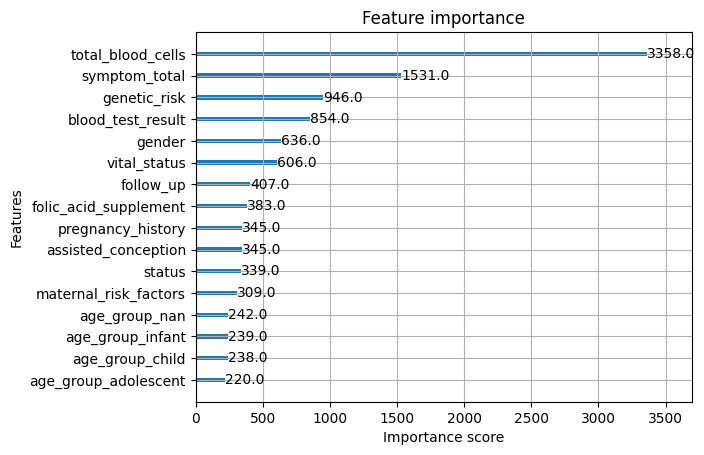

In [129]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_classifier)
plt.show()


In [130]:
y_pred = xgb_classifier.predict(X_test)

train_accuracy = accuracy_score(y_train, xgb_classifier.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

In [131]:
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.6879
Test Accuracy: 0.6300


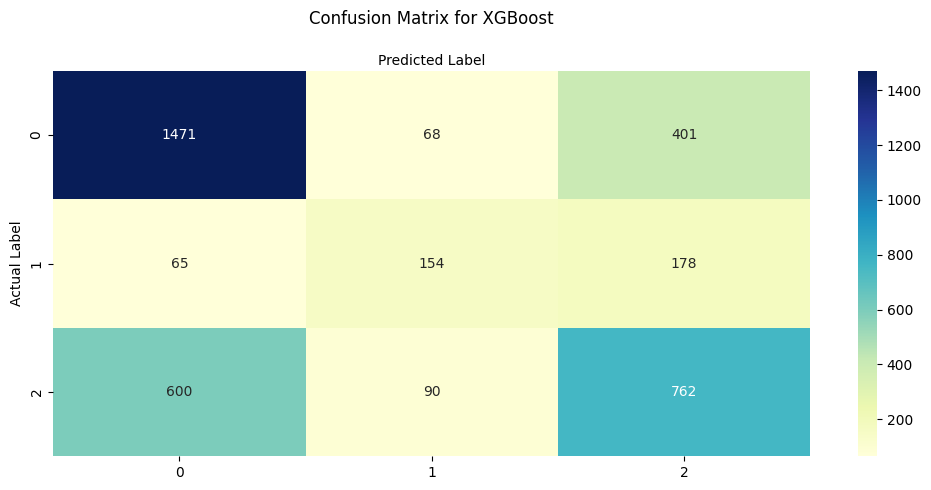

In [132]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='g')

plt.title(f'Confusion Matrix for XGBoost', y=1.1)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

plt.show()

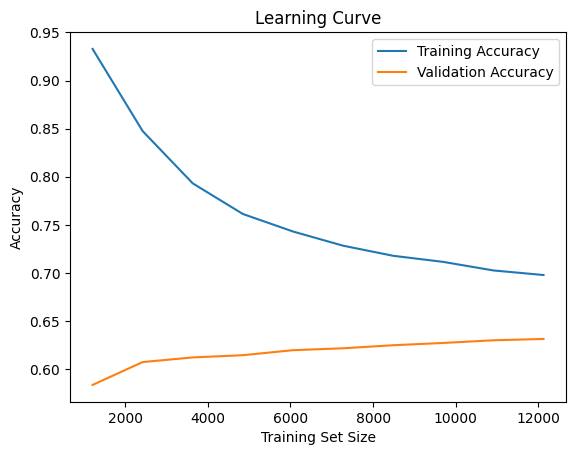

In [133]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    xgb_classifier, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, test_mean, label="Validation Accuracy")
plt.legend()
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.show()


classifiers = {
    'Logistic Regression': LogisticRegression(C=10),
    'SVC': SVC(C=10,kernel='linear'),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=15,max_depth=5),
    'AdaBoost': AdaBoostClassifier(n_estimators=50),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(n_estimators=100)

}

In [134]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd